#Import Library and Data

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

seed = 382938
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
#unrar file
!pip install unrar
!unrar x bycott_rev.rar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from bycott_rev.rar

Creating    bycott_rev                                                OK
Extracting  bycott_rev/00000000114257.png                                  0%  OK 
Extracting  bycott_rev/00000000321655.png                                  0%  OK 
Extracting  bycott_rev/00000001112001.png                                  0%  OK 
Extracting  bycott_rev/00000001201303.png                                  0%  OK 
Extracting  bycott_rev/00000001212901.png                                  0%  OK 
Extracting  bycott_rev/00000001223004.png                                  0%  OK 
Extracting  bycott_rev/00000001231003.png                                  0%  OK 
Extracting  bycott_rev/00000001231100.png                                  0%

Define Performance

In [ ]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])
    else:
        raise Exception('Error : Cannot compute the performance metric')

#Exploratory Data Analysis

Total images:  3942
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)
Shape of image:  (87, 231, 3)


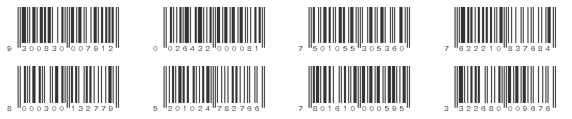

In [ ]:
# Path of data directory
data_dir = Path("/content/bycott_rev")

# Get list image
images = list(data_dir.glob("*.png"))
print("Total images: ", len(images))

# See the image information and plot images
sample_images = images[:8]
_,ax = plt.subplots(2,4, figsize=(10,2))
for i in range(8):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis('off')
plt.show()

Shape of image:  (26, 208, 3)
Shape of image:  (26, 208, 3)
Shape of image:  (26, 208, 3)
Shape of image:  (26, 208, 3)
Shape of image:  (26, 208, 3)
Shape of image:  (26, 208, 3)
Shape of image:  (26, 208, 3)
Shape of image:  (26, 208, 3)


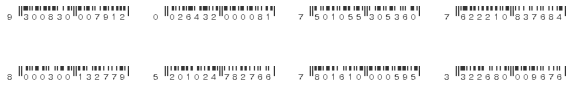

In [ ]:
sample_images = images[:8]
_,ax = plt.subplots(2,4, figsize=(10,2))
for i in range(8):
    img = cv2.imread(str(sample_images[i]))
    img = img[61:87, 0:208] #crop images
    print("Shape of image: ", img.shape)
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis('off')
plt.show()

Make Dataframe of Image dir and Labels

In [ ]:
dataset = []
labels = []
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
for img in images:
  names = img.split(os.path.sep)[-1].split(".png")[0]
  labels.append(names[1:])
  dataset.append((str(img), names[1:]))
dataset = pd.DataFrame(dataset, columns=["data_dir", "labels"], index=None)
dataset = dataset.sample(frac=1.0).reset_index(drop=True)
#Information of unique characters and length of labels
characters = set(char for label in labels for char in label)
max_length = max([len(label) for label in labels])

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", sorted(characters))
print('Maximum length of barcode: ', max_length)
dataset

Number of images found:  3942
Number of labels found:  3942
Number of unique characters:  10
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Maximum length of barcode:  13


,data_dir,labels
0,/content/bycott_rev/05449000092038.png,5449000092038
1,/content/bycott_rev/00000086927383.png,0000086927383
2,/content/bycott_rev/05000112592023.png,5000112592023
3,/content/bycott_rev/07622210996916.png,7622210996916
4,/content/bycott_rev/09343888000122.png,9343888000122
...,...,...
3937,/content/bycott_rev/04800888170910.png,4800888170910
3938,/content/bycott_rev/07613034636102.png,7613034636102
3939,/content/bycott_rev/05690541008150.png,5690541008150
3940,/content/bycott_rev/05000112544633.png,5000112544633


#Split Train-Testing

In [ ]:
# Function generate_arrays to make an array of images and labels
def generate_arrays(df):
  img_height, img_width = 87, 231
  num_items = len(df)
  images = np.zeros((num_items, 26, 208), dtype=np.float32) #total pixel after crop image
  labels = [0]*num_items
  im_dir = df["data_dir"]
  for i in range(num_items):
    imma = cv2.imread(im_dir[i])
    imma = cv2.resize(imma, (img_width,img_height)) #resize img_height and img_width
    imma = imma[61:87, 0:208] #crop images
    imma = cv2.cvtColor(imma, cv2.COLOR_BGR2GRAY) #convert RGB to grayscale
    imma = (imma/255.0).astype(np.float32) #normalize and convert to float
    images[i, :, :] = imma
    label = list(map(int, df["labels"][i]))       
    labels[i] = label
  images = tf.transpose(images, perm=[0, 2, 1])
  return images.numpy(), np.array(labels)

In [ ]:
# Split the dataset into training and validation sets
training_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  3153
Number of validation samples:  789


In [ ]:
# Build training_images and training_labels
training_images, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_images.shape)
print("Number of training labels: ", training_labels.shape)


# Build validation_images and validation_labels
validation_images, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_images.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training images:  (3153, 208, 26)
Number of training labels:  (3153, 13)
Number of validation images:  (789, 208, 26)
Number of validation labels:  (789, 13)


In [ ]:
#Image data generator to load image to fed into training
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  # add another dimension to the data
  training_images = np.expand_dims(training_images,axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  # Instantiate the ImageDataGenerator class 
  train_datagen = ImageDataGenerator()

  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=26) 

  
  # Instantiate the ImageDataGenerator class 
  validation_datagen = ImageDataGenerator()

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=26) 

  return train_generator, validation_generator

In [ ]:
# Test the generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (3153, 208, 26, 1)
Labels of training generator have shape: (3153, 13)
Images of validation generator have shape: (789, 208, 26, 1)
Labels of validation generator have shape: (789, 13)


Training Model

In [ ]:
def build_model():
    
    # Inputs model
    input_img = layers.Input(shape=(208,26,1), name="images", dtype="float32") 

    # Convolution Blocks
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)


    # Reshape to "split" the volume in 13 time-steps
    x = layers.Reshape(target_shape=(13,1536), name='reshape')(x)

    # Fully connected layers
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense2")(x)
   
    # Output layer consist 10 labels
    output = layers.Dense(10, activation="softmax", name="dense3")(x) 
    
    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_classifier_based_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 208, 26, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 208, 26, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 104, 13, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 104, 13, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 52, 6, 64)         0         
                                                                 
 reshape (Reshape)           (None, 13, 1536)          0         
                                                                 
 dense1 (Dense)              (None, 13, 

In [ ]:
#train model
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=validation_generator)

Epoch 1/5
122/122 [==============================] - 12s 12ms/step - loss: 0.7431 - accuracy: 0.7932 - val_loss: 0.0275 - val_accuracy: 0.9991
Epoch 2/5
122/122 [==============================] - 1s 9ms/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.0102 - val_accuracy: 0.9995
Epoch 3/5
122/122 [==============================] - 1s 9ms/step - loss: 0.0077 - accuracy: 0.9995 - val_loss: 0.0090 - val_accuracy: 0.9995
Epoch 4/5
122/122 [==============================] - 1s 9ms/step - loss: 0.0067 - accuracy: 0.9996 - val_loss: 0.0065 - val_accuracy: 0.9995
Epoch 5/5
122/122 [==============================] - 1s 9ms/step - loss: 0.0058 - accuracy: 0.9996 - val_loss: 0.0077 - val_accuracy: 0.9995


#Evaluation Model

Plot accuracy and loss

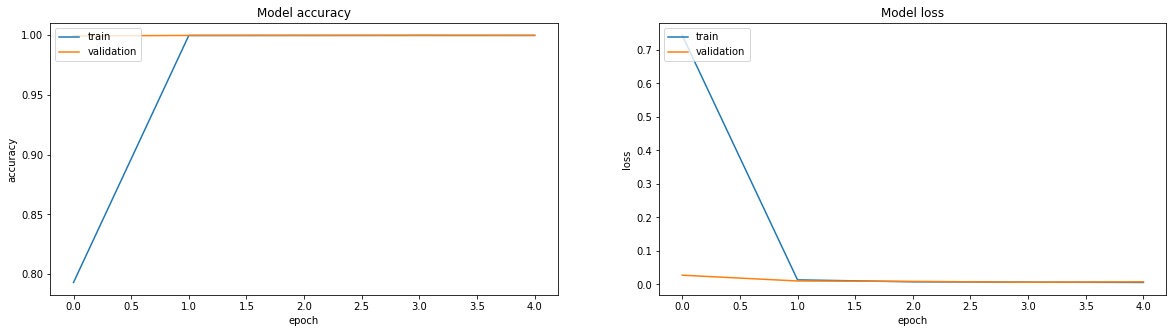

In [ ]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluation performances

In [ ]:
validation_pred = model.predict(validation_images)
validation_pred = np.argmax(validation_pred, axis=2)
compute_perf_metric(validation_pred, validation_labels)

0.9995125280296383

Check and compare prediction result

In [ ]:
print(validation_pred[230:233])
print('Berikut yang asli :')
print(validation_labels[230:233])

[[5 4 4 9 0 0 0 0 6 1 7 6 8]
 [0 0 4 9 0 0 0 0 0 1 2 3 5]
 [0 0 2 8 0 0 0 5 1 4 5 0 1]]
Berikut yang asli :
[[5 4 4 9 0 0 0 0 6 1 7 6 8]
 [0 0 4 9 0 0 0 0 0 1 2 3 5]
 [0 0 2 8 0 0 0 5 1 4 5 0 1]]


In [ ]:
model.save('barcode_model')

INFO:tensorflow:Assets written to: barcode_model/assets


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/barcode_model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)